In [ ]:
#%pip install missingno
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

#LIMIT TO 50 ROWS FOR EASE
#reference
df_icd_ref = pd.read_csv('/home/bhux/mikayla/ProjectLLM-hlth/Superutil/hosp/d_icd_diagnoses.csv.gz', compression='gzip').head(50)
df_proc_ref = pd.read_csv('/home/bhux/mikayla/ProjectLLM-hlth/Superutil/hosp/d_icd_procedures.csv.gz', compression='gzip').head(50)
#data
df_demo = pd.read_csv('/home/bhux/mikayla/ProjectLLM-hlth/Superutil/hosp/admissions.csv.gz', compression='gzip').head(50)
df_diag = pd.read_csv('/home/bhux/mikayla/ProjectLLM-hlth/Superutil/hosp/diagnoses_icd.csv.gz', compression='gzip').head(50)
df_ptnt = pd.read_csv('/home/bhux/mikayla/ProjectLLM-hlth/Superutil/hosp/patients.csv.gz', compression='gzip').head(50)

#----------------------------------visualize data-----------------------------------------------------
#----icd codes data----
icd_code_diag_ref = df_icd_ref['icd_code']
long_title_diag_ref = df_icd_ref['long_title']
icd_version_diag_ref = df_icd_ref['icd_version']

icd_code_proc_ref = df_proc_ref['icd_code']
long_title_proc_ref = df_proc_ref['long_title']
icd_version_proc_ref = df_proc_ref['icd_version']

#---demographic data---
#patient identifiers
hadm_id = df_demo['hadm_id']
subject_id = df_demo['subject_id']

#time spent, death time
admittime = df_demo['admittime']
dischtime = df_demo['dischtime']
edregtime = df_demo['edregtime']
edouttime = df_demo['edouttime']
deathtime = df_demo['deathtime']

#clinical info
hospital_expire_flag = df_demo['hospital_expire_flag']
admission_type = df_demo['admission_type']
admission_location = df_demo['admission_location']
discharge_location = df_demo['discharge_location']

#demographics
insurance = df_demo['insurance']
language = df_demo['language']
marital_status = df_demo['marital_status']
race = df_demo['race']

#---diagnosis data---
hadm_id = df_diag['hadm_id']
subject_id = df_diag['subject_id']
seq_num = df_diag['seq_num']
icd_code = df_diag['icd_code']
icd_version = df_diag['icd_version']

#---patient data---
subject_id = df_ptnt['subject_id']
gender = df_ptnt['gender']
anchor_age = df_ptnt['anchor_age']
anchor_year = df_ptnt['anchor_year']
anchor_year_group = df_ptnt['anchor_year_group']
#----------------------------------------------------------------------------------------------------------------

# Merge demographic and patient data
df = pd.merge(df_demo, df_ptnt[['subject_id', 'gender', 'anchor_age']], on='subject_id', how='left')

# Group ICD diagnostic data
df_diag_grouped = df_diag.groupby('hadm_id').agg({
    'icd_code': list,
    'seq_num': list,
    'icd_version': list
}).reset_index()

# Merge grouped ICD data
df = pd.merge(df, df_diag_grouped, on='hadm_id', how='left')

# Fill missing insurance values
df['insurance'] = df['insurance'].fillna('None')

#display(df)



,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,marital_status,race,edregtime,edouttime,hospital_expire_flag,gender,anchor_age,icd_code,seq_num,icd_version
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,...,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,F,52,"[5723, 78959, 5715, 07070, 496, 29680, 30981, ...","[1, 2, 3, 4, 5, 6, 7, 8]","[9, 9, 9, 9, 9, 9, 9, 9]"
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P784FA,EMERGENCY ROOM,HOME,Medicaid,...,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0,F,52,"[07071, 78959, 2875, 2761, 496, 5715, V08, 3051]","[1, 2, 3, 4, 5, 6, 7, 8]","[9, 9, 9, 9, 9, 9, 9, 9]"
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P19UTS,EMERGENCY ROOM,HOSPICE,Medicaid,...,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0,F,52,"[07054, 78959, V462, 5715, 2767, 2761, 496, V0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9]"
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,...,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0,F,52,"[45829, 07044, 7994, 2761, 78959, 2767, 3051, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]"
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P39NWO,EMERGENCY ROOM,NaN,None,...,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0,F,19,[30500],[1],[9]
5,10000084,23052089,2160-11-21 01:56:00,2160-11-25 14:52:00,NaN,EW EMER.,P42H7G,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,2160-11-20 20:36:00,2160-11-21 03:20:00,0,M,72,"[G3183, F0280, R441, R296, E785, Z8546]","[1, 2, 3, 4, 5, 6]","[10, 10, 10, 10, 10, 10]"
6,10000084,29888819,2160-12-28 05:11:00,2160-12-28 16:07:00,NaN,EU OBSERVATION,P35NE4,PHYSICIAN REFERRAL,NaN,Medicare,...,MARRIED,WHITE,2160-12-27 18:32:00,2160-12-28 16:07:00,0,M,72,"[R4182, G20, F0280, R609]","[1, 2, 3, 4]","[10, 10, 10, 10]"
7,10000108,27250926,2163-09-27 23:17:00,2163-09-28 09:04:00,NaN,EU OBSERVATION,P40JML,EMERGENCY ROOM,NaN,None,...,SINGLE,WHITE,2163-09-27 16:18:00,2163-09-28 09:04:00,0,M,25,NaN,NaN,NaN
8,10000117,22927623,2181-11-15 02:05:00,2181-11-15 14:52:00,NaN,EU OBSERVATION,P47EY8,EMERGENCY ROOM,NaN,Medicaid,...,DIVORCED,WHITE,2181-11-14 21:51:00,2181-11-15 09:57:00,0,F,48,NaN,NaN,NaN
9,10000117,27988844,2183-09-18 18:10:00,2183-09-21 16:30:00,NaN,OBSERVATION ADMIT,P13ACE,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Medicaid,...,DIVORCED,WHITE,2183-09-18 08:41:00,2183-09-18 20:20:00,0,F,48,NaN,NaN,NaN


        subject_id   hadm_id            admittime            dischtime  \
0         10000032  22595853  2180-05-06 22:23:00  2180-05-07 17:15:00   
1         10000032  22841357  2180-06-26 18:27:00  2180-06-27 18:49:00   
2         10000032  25742920  2180-08-05 23:44:00  2180-08-07 17:50:00   
3         10000032  29079034  2180-07-23 12:35:00  2180-07-25 17:55:00   
4         10000068  25022803  2160-03-03 23:16:00  2160-03-04 06:26:00   
...            ...       ...                  ...                  ...   
546023    19999828  25744818  2149-01-08 16:44:00  2149-01-18 17:00:00   
546024    19999828  29734428  2147-07-18 16:23:00  2147-08-04 18:10:00   
546025    19999840  21033226  2164-09-10 13:47:00  2164-09-17 13:42:00   
546026    19999840  26071774  2164-07-25 00:27:00  2164-07-28 12:15:00   
546027    19999987  23865745  2145-11-02 21:38:00  2145-11-11 12:57:00   

                  deathtime  admission_type admit_provider_id  \
0                       NaN          URGENT   

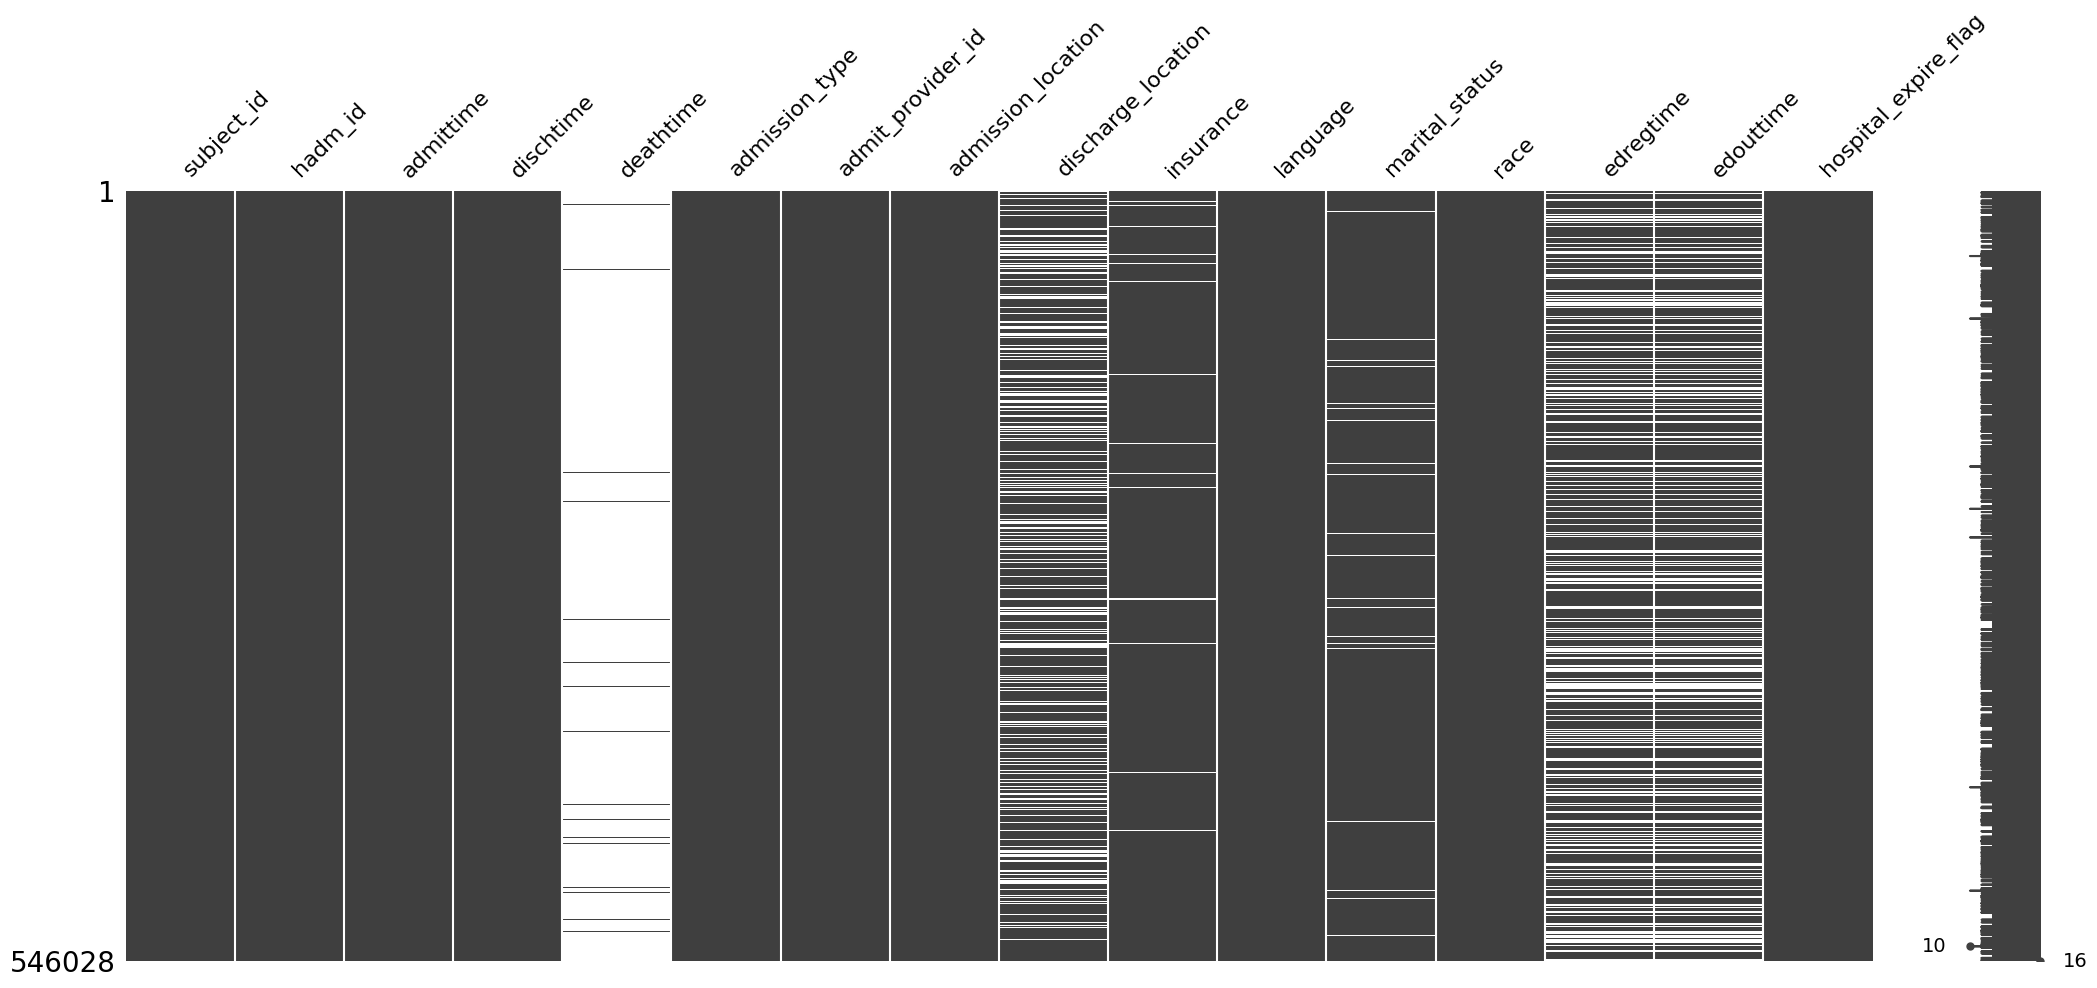

In [9]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

df = pd.read_csv('/home/bhux/mikayla/ProjectLLM-hlth/Superutil/hosp/admissions.csv.gz', compression='gzip')

print(df)
# print("dataframe info: " , df.info())
# print("nulls:", df.isnull().sum())
# print("dataframe shape:" ,df.shape)  # (rows, columns)
msno.matrix(df)  # Shows a heatmap of missing values
plt.show()

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
model = AutoModel.from_pretrained("medicalai/ClinicalBERT")



/home/bhux/mikayla/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
